In [ ]:
# Software Name : TimeStress
# SPDX-FileCopyrightText: Copyright (c) Orange SA
# SPDX-License-Identifier: MIT

# This software is distributed under the MIT License,
# see the "LICENSE.txt" file for more details or https://spdx.org/licenses/MIT.html

# Authors: see CONTRIBUTORS.md
# Software description: Evaluating the Consistency of the Temporal Representation of Facts in Large Language Models

# **Goal of notebook**: The creation of the TimeStress Dataset

The purpose of this notebook is to create the TimeStress from scratch based on the preprocessed version of Wikidata of **January 4, 2021**.

A description of the build process of TimeStress can be found directly in our [paper](https://arxiv.org/abs/2502.01220) in the Appendix.

In [1]:
# Importing packages and set constants

import os
from ke_utils.glob_core import TimeUnit

from wikidata_tools.core import Relation, TimedTripleQuery
from wikidata_tools.wikidata import TempWikidata, WikidataPrepStage
from wikidata_tools.core import Interval
from wikidata_tools.core import TimedTriple
import pandas as pd
from lm_tools.core import LanguageModel
from lm_tools.core import LogProbability
import torch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from wikidata_tools.wikidata import WikidataPopularity
from wikidata_tools.core import Literal
from wikidata_tools.core import Date, enable_level_heterogeneous_comparison

pd.set_option('display.max_colwidth', None)
# Max value for the relative distance
MAX_ALPHA = 5
# Define alpha steps
ALPHA_STEP = 0.05

gran2char = {
    TimeUnit.DAY : 'D',
    TimeUnit.MONTH : 'M',
    TimeUnit.YEAR : 'Y'
}
BANNED_RELATIONS = ["P47"]
REFERENCE_DATE = Date.from_string("2020-01-01")

# Step 1: Quintuple Collection 

In [ ]:
# Initializing Wikidata objects to retrieve quintuples and to compute their popularity
wd = TempWikidata('20210104', WikidataPrepStage.PREPROCESSED)
raw_wd = TempWikidata('20210104', WikidataPrepStage.ALMOST_RAW)
wikipop = WikidataPopularity(wd.time)

In [ ]:
# Collect all quintuples (s,r,o,a,b) in Wikidata such that 'o' is not a literal (e.g., A quantity, a date) and at least 'a' or 'b' are provided
all_facts = []
for fact in wd.find(TimedTripleQuery()):
    fact : TimedTriple
    if isinstance(fact.object, Literal) or fact.valid_between.start is None and fact.valid_between.end is None:
        continue
    all_facts.append(fact)

In [ ]:
len(all_facts)

2149106

In [ ]:
# Use this code as a progress checkpoint if needed
# pd.Series(all_facts).to_pickle('all_facts.pkl')
# all_facts = pd.read_pickle('all_facts.pkl')

In [ ]:
# Keep only quintuples (s,r,o,a,b) such that no other quintuple (s,r,o,a',b') exists (to assume that all dates outside [a,b] are necessarily incorrect)

from collections import defaultdict

def full_group_by(l, key=lambda x: x):
    d = defaultdict(list)
    for item in l:
        d[key(item)].append(item)
    return d.items()

gb = [list(fact) for _, fact in full_group_by(all_facts, key=lambda x : x.to_sro())]
single_spike = [fact[0] for fact in gb if len(fact) == 1]
multi_spike = [fact[0] for fact in gb if len(fact) > 1]

In [ ]:
print("Proportion of multi-peaks facts : %s" % (len(multi_spike) / (len(multi_spike) + len(single_spike))))

Proportion of multi-peaks facts : 0.062259659496380876


In [ ]:
import random
print('Sample of facts (s,r,o,a,b) where there is only a single period v where (s,r,o) is valid:')
for fact in random.sample(single_spike, 10):
    raw_wd.inject_info(fact)
    print(fact)
print()

print('Sample of facts (s,r,o,a,b) where there is more than one period v where (s,r,o) is valid:')
for fact in random.sample(multi_spike, 10):
    raw_wd.inject_info(fact)
    print(fact)
print()

In [ ]:
# Compute popularity of each remaining fact

subject_pop = np.array(wikipop.get_popularity([fact.subject for fact in single_spike]), dtype=np.float32)
object_pop = np.array(wikipop.get_popularity([fact.object for fact in single_spike]), dtype=np.float32)
fact_pop = np.sqrt(np.exp(subject_pop)*np.exp(object_pop))

pop = pd.DataFrame({
    'Fact' : single_spike,
    'Popularity' : fact_pop
})

In [ ]:
# In this portion of code:
# 1. All facts with a popularity inferior to 90000 are filtered-out.
# 2. All facts that lack a start or end date  are filtered-out
# 3. All facts with a validity length less than 3 years are filtered
# 4. One relation is banned due to its ambiguity

pop_ = pop[pop['Popularity'] > 90000]
pop_ = pop_[pop_['Fact'].apply(lambda x : x.valid_between.midpoint() is not None and not x.valid_between.is_point())]
pop_['LengthValid'] = pop_['Fact'].apply(lambda x : x.valid_between.end.level_completion('max').id - x.valid_between.start.level_completion('min').id)
pop_['LengthValid'] = pop_['LengthValid'].apply(lambda x : (x / np.timedelta64(1, 'D')) // 30).astype(int)
pop_ = pop_[pop_['LengthValid'] > 3*12+1] # Keep only facts valid for more than two years (12 months x 2 + 1 for safety)
pop_['Relation'] = pop_['Fact'].apply(lambda x : x.relation.id)
# raw_wd.inject_info(pop_['Relation'].tolist())
kept_relations = pop_['Relation'].unique()
kept_relations = kept_relations[[x not in BANNED_RELATIONS for x in kept_relations]]
share_lost_banned_relations = pop_['Relation'][np.isin(pop_['Relation'], [x for x in BANNED_RELATIONS])].size
share_lost_banned_relations = share_lost_banned_relations / len(pop_) 
print('Kept relations : %s' % kept_relations.tolist())
print('Banned relations : %s' % (set(Relation(x) for x in BANNED_RELATIONS) - set(kept_relations.tolist())))
print('Share of facts lost due to banned relations : %s' % share_lost_banned_relations)
pop_ = pop_[np.isin(pop_['Relation'],  kept_relations)]
raw_wd.inject_info(pop_['Fact'])
print('Number of kept facts: %s' % len(pop_))
df = pop_

Kept relations : ['P35', 'P26', 'P27', 'P119', 'P39', 'P410', 'P122', 'P6', 'P17', 'P530', 'P36', 'P38', 'P793', 'P69', 'P1376', 'P37', 'P500', 'P737', 'P54', 'P551', 'P31', 'P488', 'P140', 'P241', 'P937', 'P2094', 'P527', 'P286', 'P131', 'P102', 'P451', 'P463', 'P108', 'P2632', 'P361', 'P800', 'P449', 'P169', 'P97', 'P194', 'P1304', 'P150', 'P3320', 'P138', 'P106', 'P118', 'P1308', 'P749', 'P127', 'P6087', 'P509', 'P466', 'P607', 'P6872', 'P1038', 'P495', 'P1037', 'P159', 'P945', 'P371', 'P915', 'P859', 'P1071', 'P190', 'P2596', 'P264', 'P511', 'P710', 'P3975', 'P734', 'P85', 'P161', 'P5389', 'P641', 'P4791', 'P1875', 'P398', 'P355', 'P414', 'P1344', 'P1066', 'P3461', 'P8047', 'P180', 'P175', 'P1431']
Banned relations : {P47}
Share of facts lost due to banned relations : 0.019562179785747556
Number of kept facts: 2105


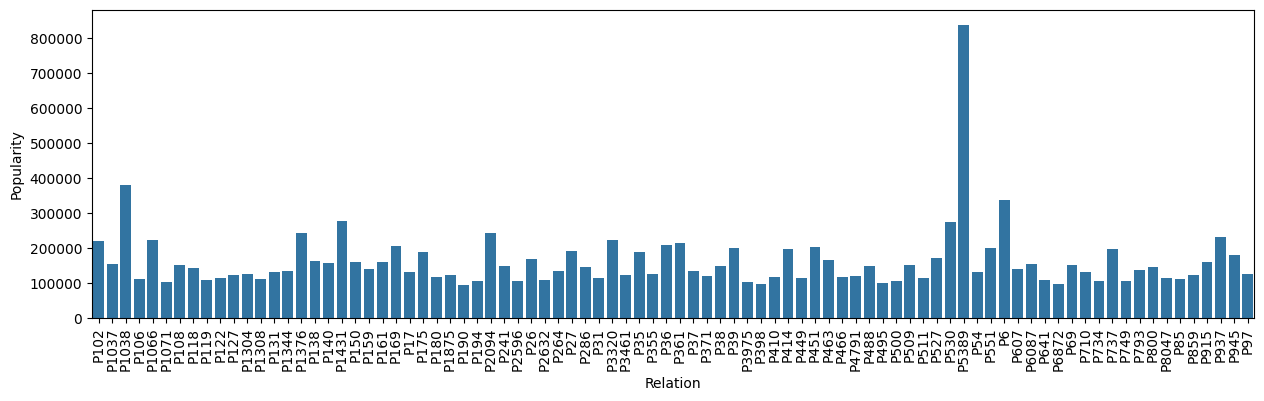

In [ ]:
# Most popular relations

plt.figure(figsize=(15,4))
relations = df.groupby('Relation')['Popularity'].mean().to_frame().reset_index()
sns.barplot(relations, x='Relation', y='Popularity')
plt.xticks(rotation=90)
plt.show()

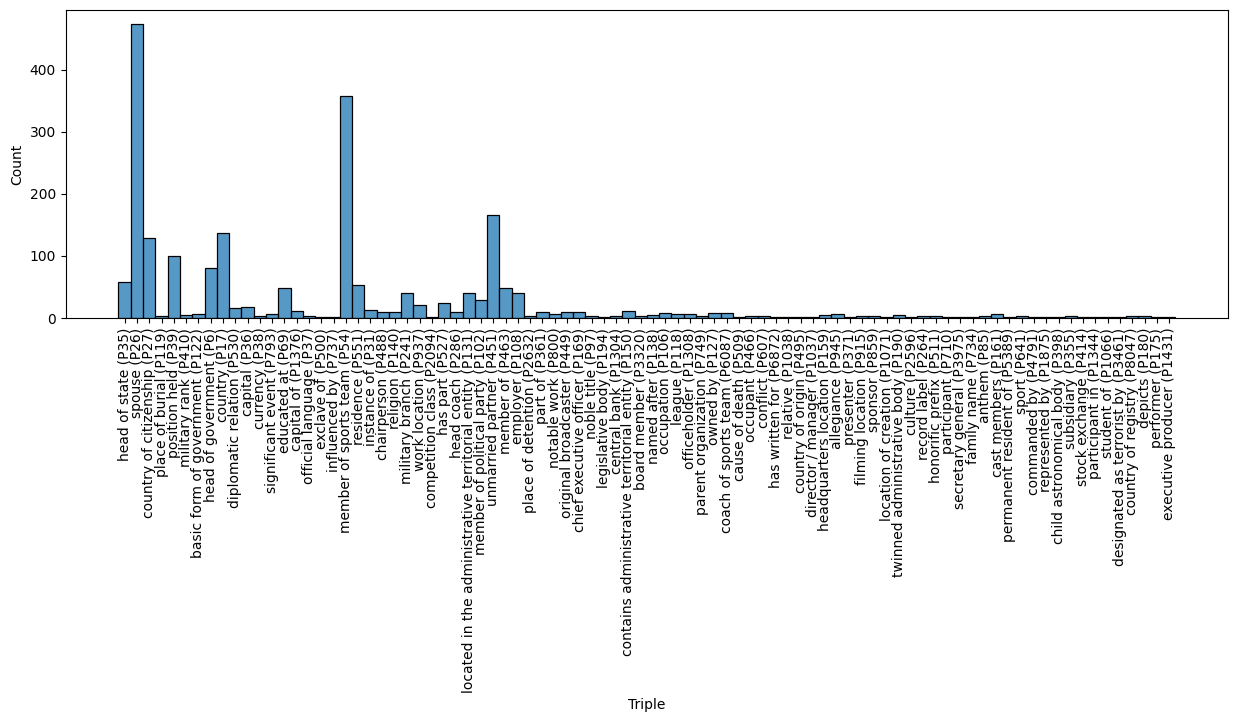

In [ ]:
# Distribution of relations in remaining facts

plt.figure(figsize=(15,4))
sns.histplot(df['Fact'].apply(lambda x : "%s (%s)" % (x.relation.label, x.relation.id)))
plt.xticks(rotation=90)
plt.show()

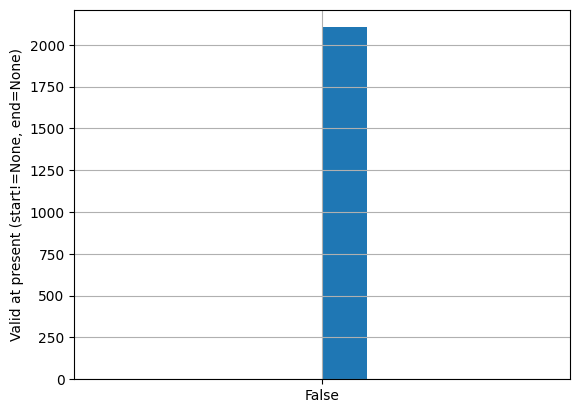

In [ ]:
# Checking that all remaining facts have a start date and an end date

df['Fact'].apply(lambda x : str(x.valid_between.midpoint() is not None)).hist()
plt.show()

In [ ]:
# Sample of remaining facts

df.sample(20)

In [ ]:
print("Popular facts sample per relation")
display(df.groupby('Relation').sample(2, replace=True))

In [ ]:
# Remove facts whose validity periods extend beyond 2020
df = df[df['Fact'].apply(lambda x : x.valid_between.end and x.valid_between.end.year <= 2020)]

In [ ]:
# Data stats
print('Number of facts : %s' % len(df))
print('Number of unique entities : %s' % len(set(x.subject for x in df['Fact']) | set(x.object for x in df['Fact'])))
print('Number of unique subjects : %s' % len(set(x.subject for x in df['Fact'])))
print('Number of unique relations : %s' % len(set(x.relation for x in df['Fact'])))
print('Number of unique objects : %s' % len(set(x.object for x in df['Fact'])))

Number of facts : 2098
Number of unique entities : 1910
Number of unique subjects : 1435
Number of unique relations : 86
Number of unique objects : 1151


# Step 2 : Quintuple verbalization

In [ ]:
# Checkpoint
# import pandas as pd
# df = pd.read_pickle('checkpoint.pkl')
# df.to_pickle('checkpoint.pkl')

In [11]:
from wikidata_tools.wikidata import TempWikidata, WikidataPrepStage
raw_wd = TempWikidata('20210104', WikidataPrepStage.ALMOST_RAW)

In [ ]:
# Verbalize all facts usiung GPT-4o (IMPORTANT: don't forget to implement verb_tools.llm.get_response_model function)

from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm
from verb_tools.core import EntityFormatter
from verb_tools.llm import LlmuVerbalizer
from verb_tools.options import DatePrecision, DateStyle

verbalizer = LlmuVerbalizer(raw_wd, "openai/gpt-4o")

def verbalize_fact(fact):
    return verbalizer.verbalize(fact)


with ThreadPoolExecutor(max_workers=32) as executor:
    all_verbalizations = list(tqdm(executor.map(verbalize_fact, df['Fact']),
                        total=len(df),
                        desc='Verbalizing facts using gpt-4o'))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/bpgh0162/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/home/bpgh0162/knowledge-editing/.venv/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


Verbalizing facts using gpt-4o:   0%|          | 0/2098 [00:00<?, ?it/s]

In [13]:
# Verbalization stats
import re
import numpy as np
from verb_tools.llm import QuestionAnswer
import random

all_verbalization_flatten = pd.Series([y for x in all_verbalizations for y in x])


def follow_right_format(verb : QuestionAnswer) -> bool:
    return re.match(r'^.+?\? .+?$', verb.text) is not None

frf = np.array([follow_right_format(v) for verbs in all_verbalizations for v in verbs])
print('Proportion of QuestionAnswers that follow the right format: %s' % frf.mean())
num_questions = pd.Series([len(x) for x in all_verbalizations])
print('Number of QuestionAnswers per fact : \n%s' % num_questions.value_counts())
verb_answer_type = pd.Series([x.answer_type for x in all_verbalization_flatten])
print('Type of answers:\n%s' % verb_answer_type.value_counts())

Proportion of QuestionAnswers that follow the right format: 1.0
Number of QuestionAnswers per fact : 
4    2045
0      53
Name: count, dtype: int64
Type of answers:
object     8116
subject      64
Name: count, dtype: int64


In [ ]:
# Failed verbalization facts are filtered as well as question facts that end with a subject and those having less than 4 verbalizations. 
all_verbalizations_cleaned = [[x for x in verbs if x.answer_type == 'object'] for verbs in all_verbalizations]
df2 = pd.DataFrame({
    'Verbs' : all_verbalizations_cleaned,
    'Fact' : df['Fact'],
})
df2 = df2[df2['Verbs'].apply(lambda x : len(x) == 4)]

In [6]:
# To generate samples
random.seed(123)
all_verbalization_flatten_clean = pd.Series([y for x in all_verbalizations_cleaned for y in x])

for i, x in enumerate(all_verbalization_flatten_clean.sample(200, random_state=42)[:50]):
    print('"%s"' % x.text, ",",  '"%s"' % x.triple)

"which basketball player was Khloé Kardashian married to? Lamar Odom" , "(Khloé Kardashian, spouse, Lamar Odom, start=2009-09-27, end=2016-12)"
"which anthem represented the Soviet Union? The Internationale" , "(Soviet Union, anthem, The Internationale, start=1923-07-06, end=1943-12-31)"
"which individual held the highest formal authority in India? Sarvepalli Radhakrishnan" , "(India, head of state, Sarvepalli Radhakrishnan, start=1962-05-13, end=1967-05-13)"
"under which record label did Dr. Dre produce and release his music? Death Row Records" , "(Dr. Dre, record label, Death Row Records, start=1991, end=1996)"
"which role did Boris Johnson serve in? Mayor of London" , "(Boris Johnson, position held, Mayor of London, start=2008-05-04, end=2016-05-07)"
"who was Bryan Lourd's partner without being married? Carrie Fisher" , "(Bryan Lourd, unmarried partner, Carrie Fisher, start=1991, end=1994)"
"who was Chris Evans dating? Jessica Biel" , "(Chris Evans, unmarried partner, Jessica Biel, 

In [7]:
latex_sample = all_verbalization_flatten_clean.to_frame()
latex_sample['Quintuple'] = latex_sample[0].apply(lambda x: x.triple)
latex_sample['Text'] = latex_sample[0].apply(lambda x: x.text)
print(latex_sample.sample(200, random_state=42).drop(columns=0).iloc[:30].to_latex(index=False))

\begin{tabular}{ll}
\toprule
Quintuple & Text \\
\midrule
(Khloé Kardashian, spouse, Lamar Odom, start=2009-09-27, end=2016-12) & which basketball player was Khloé Kardashian married to? Lamar Odom \\
(Soviet Union, anthem, The Internationale, start=1923-07-06, end=1943-12-31) & which anthem represented the Soviet Union? The Internationale \\
(India, head of state, Sarvepalli Radhakrishnan, start=1962-05-13, end=1967-05-13) & which individual held the highest formal authority in India? Sarvepalli Radhakrishnan \\
(Dr. Dre, record label, Death Row Records, start=1991, end=1996) & under which record label did Dr. Dre produce and release his music? Death Row Records \\
(Boris Johnson, position held, Mayor of London, start=2008-05-04, end=2016-05-07) & which role did Boris Johnson serve in? Mayor of London \\
(Bryan Lourd, unmarried partner, Carrie Fisher, start=1991, end=1994) & who was Bryan Lourd's partner without being married? Carrie Fisher \\
(Chris Evans, unmarried partner, Jessica 

**Analyzing of the qulity of thew verbalization on a sample of 50**:
- Most of them (49) are correct
- Only 1 bad verbalization where the model generated a non-sensical answer

*annotation file:* `annotations/annotation_quality_timestress.ods`

In [ ]:
df = df[np.isin(df['Fact'], df2['Fact'])]

In [ ]:
# Remaining facts
len(df)

2003

# Step 3: Statements Generation

In [ ]:
from copy import deepcopy
from functools import cache

triple2verb = {}

def verbalize(triple : TimedTriple, date : Date=None, granularity : TimeUnit=None) -> QuestionAnswer:
    v = random.choice(verbalize_fact(triple)) if triple not in triple2verb else deepcopy(triple2verb[triple])
    if triple not in triple2verb:
        triple2verb[triple] = deepcopy(v)
    if date:
        d = EntityFormatter.format_date_static(date, DatePrecision(granularity), DateStyle.MONTH_LETTER_AMERICAN, use_preposition_comma=True)
        v.text = d + v.text
    return v

In [15]:
def linspace_date(d1 : np.datetime64, d2 : np.datetime64, alphas : np.ndarray) -> np.datetime64:
    diff = d2 - d1
    mid = d1 + diff / 2
    dates = mid + alphas * diff
    return dates

In [24]:
def rand_month(year : int) -> np.datetime64:
    return np.datetime64('%s-%02d' % (year, random.choice(range(1,13))))

from calendar import monthrange
def rand_day(year : int, month : int) -> np.datetime64:
    return np.datetime64('%s-%02d-%02d' % (year, month, random.choice(range(1, monthrange(year, month)[1]+1))))

In [ ]:
# In this code section, all statements of all facts on the 3 date precisions are generated using the questions previously generated with GPT-4o.
# A statement is a sentence that starts with a temporal context (a date), then, a question that ends with a question mark and then finally the answer.
# For example: "In 2011, who was the president of USA? Barack Obama"
# NOTE: Statements with a future date (beyond 2020) are filtered-out.

from itertools import zip_longest

from ke_utils.general import all_equal, uniquifier
from ke_utils.glob_core import TimeUnit
from collections import defaultdict

random.seed(123)
def get_bounds(fact):
    s = fact.valid_between.start.level_completion('min')
    e = fact.valid_between.end
    if e is not None:
        e = e.level_completion('max')
    else:
        e = REFERENCE_DATE
    return s,e

def compute_alphas(dates : list[Date], s : np.datetime64, e : np.datetime64) -> list[float]:
    diff = e - s
    mid = s + diff / 2
    alphas = []
    for date in dates:
        date = date.level_completion('mean')
        alphas.append((date.id - mid) / diff)
    return alphas

def test_alphas(dates, s, e, alphas):
    assert (np.array(compute_alphas(dates,s,e)) == alphas).all()



grans = [TimeUnit.YEAR, TimeUnit.MONTH, TimeUnit.DAY]
timestress_data = []
df_columns = ['Fact', 'Time', 'Alpha', 'Statement', 'IsCorrect', 'FactPop', 'Granularity']
alphas = np.arange(-MAX_ALPHA, MAX_ALPHA + 0.0001, ALPHA_STEP)
stats = {}

print(len(alphas))
for _, (fact, pop, _, _) in tqdm(df.iterrows(), "Verbalizing facts", len(df)):
    s,e = get_bounds(fact)
    if e.year >= 2021:
        continue
    gran_count_correct = defaultdict(lambda : 0)
    gran_count_incorrect = defaultdict(lambda : 0)
    gran_count_transitional = defaultdict(lambda : 0)
    gran_count_discarded = defaultdict(lambda : 0)
    year_dates = [Date.from_string(str(x.astype('datetime64[%s]' % gran2char[TimeUnit.YEAR]))) for x in linspace_date(
            s.level_completion('mean').id, e.level_completion('mean').id, alphas
    )]
    year_dates = uniquifier([x for x in year_dates if x.year < 2021])
    discarded_years = set()
    month_dates = []
    for gran in grans:
        s,e = get_bounds(fact)
        if gran == TimeUnit.YEAR:
            times = [x.id for x in year_dates]
        elif gran == TimeUnit.MONTH:
            times = [rand_month(x.year) for x in year_dates]
            month_dates = [Date(x) for x in times]
        else:
            times = [rand_day(x.year, x.month) for x in month_dates]
        alphas_ = compute_alphas([Date(x) for x in times], s.level_completion('mean').id, e.level_completion('mean').id)

        times.append(None)
        for time, alpha in zip_longest(times, alphas_, fillvalue=None):
            gran_count_correct[gran] += 1
            date = Date.from_string(str(time)) if time is not None else None
            qa = verbalize(fact, date, gran)
            text = qa.text
            discarded_for_equity = False
            if time is not None:
                min_max_inter = Interval(date.level_completion('min'), date.level_completion('max'))
                with enable_level_heterogeneous_comparison():
                    inter = min_max_inter.intersection(Interval(s,e))
                if date.year in discarded_years:
                    is_correct = 'Discarded'
                else:
                    is_correct = 'Incorrect' if inter is None else 'Correct' if inter == min_max_inter else 'Transitional'
                if is_correct == 'Correct':
                    gran_count_correct[gran] += 1
                elif is_correct == 'Incorrect':
                    gran_count_incorrect[gran] += 1
                elif is_correct == 'Transitional':
                    discarded_years.add(date.year)
                    gran_count_transitional[gran] += 1
                else:
                    gran_count_discarded[gran] += 1
            else:
                is_correct = 'No context'
            timestress_data.append((fact, time, alpha, text, is_correct, pop, gran))
        assert gran_count_transitional[gran] in [0,1,2]
        assert gran_count_discarded[gran] in [0,1,2]
    assert all_equal(gran_count_correct.values()) and all_equal(gran_count_incorrect.values())

timestress = pd.DataFrame(timestress_data, columns=df_columns)

201


/home/bpgh0162/knowledge-editing/.venv/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


Verbalizing facts:   0%|          | 0/2008 [00:00<?, ?it/s]

In [ ]:
timestress.groupby(['IsCorrect', 'Granularity']).count()

In [ ]:
# A random model would only have a 0.004 chance of distinguishing perfectly between correct and incorrect statements of a fact in the worst case scenario.
import math
import numpy as np

timestress_ = timestress[timestress['Fact'].apply(lambda x : x.valid_between.end.year < 2021)]

x = timestress_[np.isin(timestress_['IsCorrect'], ['Incorrect', 'Correct'])].groupby(['Fact', 'Granularity', 'IsCorrect'], sort=False)['Time'].count().reset_index(2)
f = lambda x : math.factorial(x)
random_baseline_perf = x.loc[x['IsCorrect'] == 'Incorrect', 'Time'].apply(f) * x.loc[x['IsCorrect'] == 'Correct', 'Time'].apply(f) / (x.loc[x['IsCorrect'] == 'Incorrect', 'Time'] + x.loc[x['IsCorrect'] == 'Correct', 'Time']).apply(f)
print(random_baseline_perf.describe())
print(random_baseline_perf.max()) # Output: 0.004329004329004329

count     6009.000000
unique     632.000000
top          0.000011
freq       201.000000
Name: Time, dtype: float64

In [ ]:
# Maximum number of correct and incorrect statements across all facts.
x.groupby(['IsCorrect']).max()

,Time
IsCorrect,
Correct,21
Incorrect,180


In [ ]:
# TimeStress stats
print('Number of statements : %s' % len(timestress_))
print('Number of unique entities : %s' % len(set(x.subject for x in timestress_['Fact']) | set(x.object for x in timestress_['Fact'])))
print('Number of unique subjects : %s' % len(set(x.subject for x in timestress_['Fact'])))
print('Number of unique relations : %s' % len(set(x.relation for x in timestress_['Fact'])))
print('Number of unique objects : %s' % len(set(x.object for x in timestress_['Fact'])))

In [ ]:
timestress_.to_pickle('timestress.pkl')

**Here ends the build process of TimeStress**